In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pickle

def read_from_pickle(path, time_steps = 5):
    f = open(path,'rb')
    x = pickle.load(f)
    f.close()
    keys = ['x','y','z','doppler', 'peakVal']
    for time_segment in range(len(x)//time_steps):
        for t in range(time_steps):
            s = np.array([x[time_segment*time_steps+t].get(k).mean() for k in keys])
            if t == 0:
                sample = s
            else:
                sample = np.vstack((sample , s))

        sample = np.expand_dims(sample, axis=0)
        if time_segment == 0:
            data = sample
        else:
            data = np.vstack((data, sample))
    return data

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Softmax, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical
# from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
import matplotlib.pyplot as plt
import pandas as pd
#from data_pp_mmwave import *
import os

data_dir = "/content/drive/My Drive/mmWaveData/"

step = 12
data  = read_from_pickle(data_dir+'data_sitting.pkl', step)
label = np.zeros(data.shape[0])

data_standing = read_from_pickle(data_dir+'data_standing.pkl', step)
data = np.vstack((data, data_standing))
label = np.append(label,np.ones(data_standing.shape[0]))

data_walking = read_from_pickle(data_dir+'data_walking.pkl', step)
data = np.vstack((data, data_walking))
label = np.append(label, 2 * np.ones(data_walking.shape[0]))
label = to_categorical(label)

X_train, X_test, y_train, y_test = train_test_split(data,label, test_size=0.2)

scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = StandardScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

for i in range(X_test.shape[2]):
    X_test[:, :, i] = scalers[i].transform(X_test[:, :, i]) 

opt  = Adam(lr=0.0001)
call_back = EarlyStopping(patience=2)
input_shape = X_train.shape[1:3]
model = Sequential()
model.add(LSTM(20, input_shape=input_shape, return_sequences=False))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=2000,
                validation_split=0.15,
                callbacks= [call_back],
                batch_size=32, verbose=2)

y_pred = model.predict(X_test)
results = model.evaluate(X_test,y_test,batch_size = 32)
print('test loss, test accuracy:',results)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 2,323
Trainable params: 2,323
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
2/2 - 0s - loss: 1.1633 - accuracy: 0.3265 - val_loss: 1.0793 - val_accuracy: 0.5556
Epoch 2/2000
2/2 - 0s - loss: 1.1681 - accuracy: 0.3061 - val_loss: 1.0776 - val_accuracy: 0.5556
Epoch 3/2000
2/2 - 0s - loss: 1.1285 - accuracy: 0.408

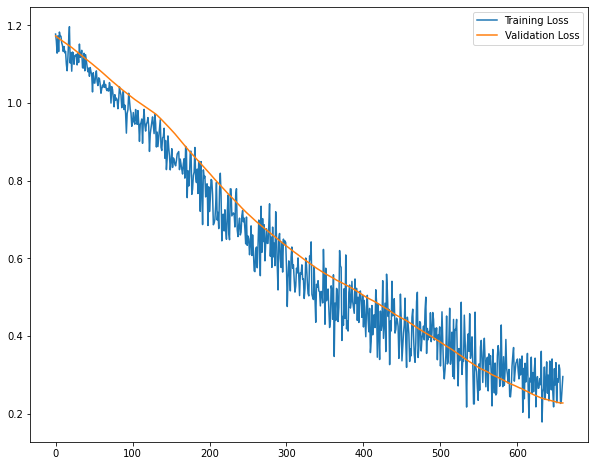

In [9]:
plt.figure(figsize=(10,8))
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.plot(hist.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'best')

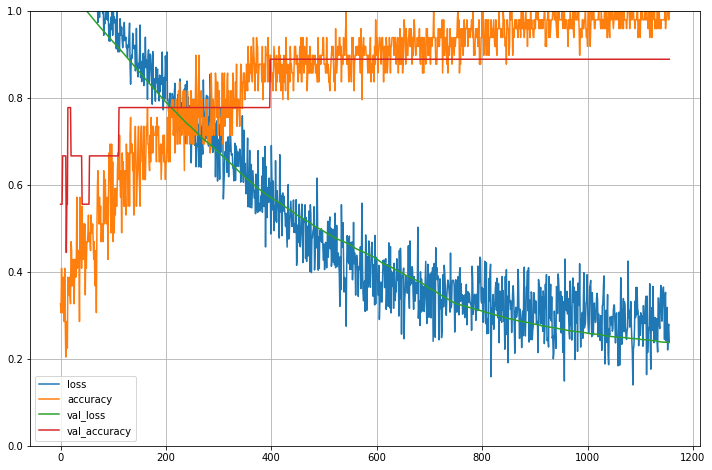

In [10]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()